<a href="https://colab.research.google.com/github/ClovisDyArx/SSL/blob/main/tp3/Fine_tuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Fine-tuning de BERT pour la classification de textes

Ce TP a pour objectif d'illustrer l'utilisation de BERT pour une tâche de classification de textes en utilisant le transfer learning. Nous utiliserons le dataset AG News qui contient des articles de presse à classifier en 4 catégories.


In [1]:
!pip install torch transformers datasets tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## 1. Préparation de l'environnement

Commençons par importer les bibliothèques nécessaires et vérifier notre environnement d'exécution.


In [2]:
# Cellule 1 : Imports et setup
import torch
from torch import nn
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Vérification du GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé : {device}")

Device utilisé : cuda



## 2. Exploration et visualisation des données

Explorons maintenant le dataset AG News pour comprendre sa structure et sa distribution.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Structure du dataset :
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Exemples du dataset :

Exemple 1:
Texte : Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
Label : 2

Exemple 2:
Texte : Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
Label : 2

Exemple 3:
Texte : Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
Label : 2

Distribution des classes

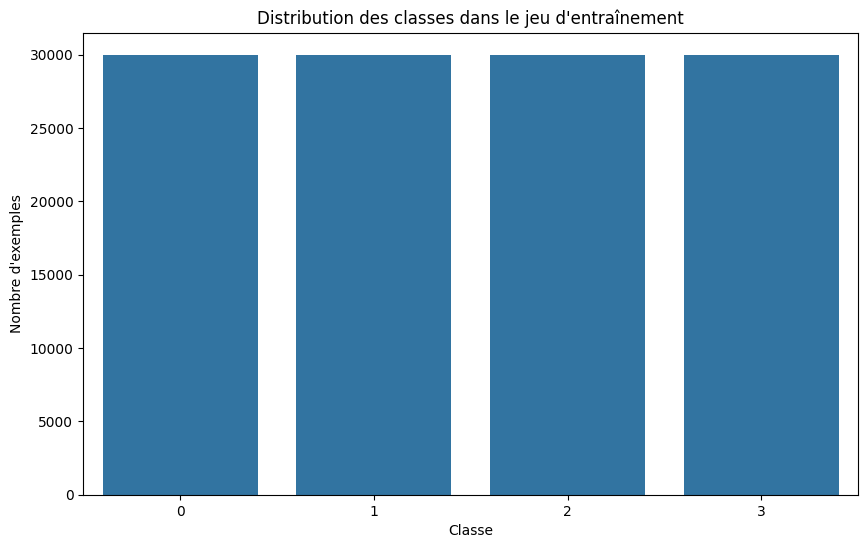

In [3]:
# Chargement du dataset AG News
dataset = load_dataset("ag_news")
print("Structure du dataset :")
print(dataset)

# Affichage de quelques exemples
print("\nExemples du dataset :")
for i in range(3):
    print(f"\nExemple {i+1}:")
    print(f"Texte : {dataset['train'][i]['text']}")
    print(f"Label : {dataset['train'][i]['label']}")

# Statistiques sur les labels
labels = [x['label'] for x in dataset['train']]
unique, counts = np.unique(labels, return_counts=True)
print("\nDistribution des classes :")
for label, count in zip(unique, counts):
    print(f"Classe {label}: {count} exemples")

# Visualisation de la distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=labels)
plt.title("Distribution des classes dans le jeu d'entraînement")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.show()


## 3. Tokenization avec BERT

La tokenization est une étape cruciale dans le traitement du texte avec BERT. Nous allons explorer comment BERT découpe le texte en tokens.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Exemple de tokenization
text = "Hello! How are you doing? 😊"
tokens = tokenizer.tokenize(text)
print(f"Texte original : {text}")
print(f"Tokens : {tokens}")

# Conversion en IDs
input_ids = tokenizer.encode(text, add_special_tokens=True)
print(f"\nInput IDs : {input_ids}")
print(f"Tokens décodés : {tokenizer.convert_ids_to_tokens(input_ids)}")

# Preprocessing
encoding = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=32,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print("\nSortie complete du tokenizer :")
print(f"Input IDs shape : {encoding['input_ids'].shape}")
print(f"Attention mask shape : {encoding['attention_mask'].shape}")
print(f"Attention mask : {encoding['attention_mask'][0]}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Texte original : Hello! How are you doing? 😊
Tokens : ['hello', '!', 'how', 'are', 'you', 'doing', '?', '[UNK]']

Input IDs : [101, 7592, 999, 2129, 2024, 2017, 2725, 1029, 100, 102]
Tokens décodés : ['[CLS]', 'hello', '!', 'how', 'are', 'you', 'doing', '?', '[UNK]', '[SEP]']

Sortie complete du tokenizer :
Input IDs shape : torch.Size([1, 32])
Attention mask shape : torch.Size([1, 32])
Attention mask : tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


## 4. Préparation des données

Création d'un Dataset personnalisé pour gérer nos données efficacement.

In [5]:
class AGNewsDataset(Dataset):
    def __init__(self, split, tokenizer, max_len=128):
        self.dataset = load_dataset("ag_news")[split]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = str(self.dataset[idx]['text'])
        label = self.dataset[idx]['label']

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



## 5. Architecture du modèle

Définition de notre modèle de classification basé sur BERT.
Points clés de l'architecture :
- Utilisation de BERT pré-entraîné comme base
- Ajout d'une couche de classification
- Gel des paramètres de BERT pour le transfer learning

In [13]:
class BERTClassifier(nn.Module):
    def __init__(self, num_classes=4, freeze_bert=True):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        ############# Code ##############
        self.output = nn.Linear(768, 4)
        #################################

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):

        ############# Code ##############
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = x.pooler_output
        x = self.output(x)
        return x
        #################################



# Création du modèle et analyse des paramètres
model = BERTClassifier(num_classes=4, freeze_bert=True)

# Analyse des paramètres
############# Code ##############
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params
#################################

print("Analyse des paramètres du modèle :")
print(f"Paramètres totaux : {total_params:,}")
print(f"Paramètres entraînables : {trainable_params:,}")
print(f"Paramètres gelés : {frozen_params:,}")

Analyse des paramètres du modèle :
Paramètres totaux : 109,485,316
Paramètres entraînables : 3,076
Paramètres gelés : 109,482,240


## 6. Fonctions d'entraînement et d'évaluation

Implémentation des fonctions nécessaires pour l'entraînement et l'évaluation du modèle.
Ces fonctions orchestrent :
- L'entraînement par batch
- Le calcul de la loss et de l'accuracy
- L'évaluation sur le jeu de test
- L'affichage de la progression

In [8]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(data_loader, desc='Training')
    for batch in progress_bar:
        ############# Code ##############
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predictions = torch.max(outputs, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.shape[0]
        #################################

    return total_loss / len(data_loader), correct_predictions / total_predictions

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            _, predictions = torch.max(outputs, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.shape[0]
            total_loss += loss.item()

    return (total_loss / len(data_loader),
            correct_predictions / total_predictions,
            all_predictions,
            all_labels)

## 7. Entraînement du modèle

In [ ]:
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

# Création des dataloaders
train_dataset = AGNewsDataset('train', tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = AGNewsDataset('test', tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Préparation du modèle
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Suivi des métriques
history = {
    'train_loss': [], 'train_acc': [],
    'test_loss': [], 'test_acc': []
}

# Entraînement
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')

    ############# Code ##############
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, predictions, labels = evaluate(model, test_loader, criterion, device)
    #################################


Epoch 1/3


Training: 100%|██████████| 3750/3750 [16:06<00:00,  3.88it/s]



Epoch 2/3


Training: 100%|██████████| 3750/3750 [16:08<00:00,  3.87it/s]



Epoch 3/3


Training:  60%|█████▉    | 2240/3750 [09:37<06:22,  3.95it/s]

## 8. Analyse des résultats

Visualisation et analyse des performances du modèle.
Cette section nous permet de :
- Visualiser les courbes d'apprentissage
- Analyser la matrice de confusion
- Identifier les forces et faiblesses du modèle

In [ ]:
# Courbes d'apprentissage
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['test_loss'], label='Test')
plt.title('Loss au cours des époques')
plt.xlabel('Époque')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['test_acc'], label='Test')
plt.title('Accuracy au cours des époques')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies classes')
plt.show()


## 9. Test sur des exemples réels

Utilisation du modèle entraîné sur de nouveaux exemples.
Testez le modèle avec vos propres textes pour évaluer ses performances dans des conditions réelles.


In [ ]:
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
test_texts = [
    "NASA successfully launches new Mars rover to explore the red planet",
    "Manchester United wins dramatic match against Liverpool",
    "Apple stock reaches all-time high after strong quarterly earnings",
    "New study reveals breakthrough in quantum computing research"
]

############# Code ##############


#################################